# Community Finding - Algorithm Comparision
## Jake Carlson

## Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph
import importlib
import methods
import uuid

In [ ]:
df_q = pd.read_csv("./data/2008-questions.csv")
df_a = pd.read_csv("./data/2008-answers.csv")
df_t = pd.read_csv("./data/2008-tags.csv")

# remove NaN owner ids
df_q = df_q[np.isfinite(df_q.OwnerUserId.values)]
df_a = df_a[np.isfinite(df_a.OwnerUserId.values) & df_a.ParentId.isin(df_q.Id)]

df_q.OwnerUserId = df_q.OwnerUserId.astype(np.int)
df_a.OwnerUserId = df_a.OwnerUserId.astype(np.int)

df_q['qid'] = [str(uuid.uuid4()) for _ in range(len(df_q))]
df_a['qid'] = [df_q['qid'].values[df_q.Id == a][0] for a in df_a.ParentId.values]

In [ ]:
owner_to_uid = {}
def get_uids(df):
    uids = []
    for i, r in df.iterrows():
        owner = r['OwnerUserId']
        uid = None
        if owner in owner_to_uid.keys():
            uid = owner_to_uid[owner]
        else:
            uid = str(uuid.uuid4())
            owner_to_uid[owner] = uid
        uids.append(uid)
    return uids

df_q['uid'] = get_uids(df_q)
df_a['uid'] = get_uids(df_a)

In [ ]:
df_q.head()

In [ ]:
df_a.head()

In [ ]:
df_t.head()

In [ ]:
df_t.info()

In [ ]:
df_q.info()

## Questions Only

In [ ]:
tags_to_questions = {}
for g, data in df_t.groupby(['Tag']):
    tags_to_questions[g] = set(df_q.qid[df_q.Id.isin(data.Id)].values)

questions_to_questions = {}
for t, quids in tags_to_questions.items():
    for i, q in enumerate(quids):
        if q in questions_to_questions.keys():
            questions_to_questions[q].update(quids)
        else:
            questions_to_questions[q] = set(quids)
        questions_to_questions[q].remove(q)

questions = list(questions_to_questions.keys())
questions_to_idx = {}
for i, q in enumerate(questions):
    questions_to_idx[q] = i

In [ ]:
edges = []
for k, v in questions_to_questions.items():
    for q in v:
        edges.append((questions_to_idx[k], questions_to_idx[q]))

In [ ]:
graph = igraph.Graph(edges=edges, directed=False).simplify(multiple=True, loops=False)
graph.vs['name'] = questions

In [ ]:
largest = get_largest_component(graph)

## Karate Club

In [2]:
karate = igraph.Graph.Read_GML('./data/karate/karate.gml')
karate.vs['id'] = list(range(len(karate.vs)))
karate.vs['label'] = karate.vs['id']

In [3]:
def get_largest_component(g):
    comps = g.components()
    sizes = comps.sizes()
    idx_largest = sizes.index(max(sizes))
    return comps.subgraph(idx_largest)

In [4]:
largest = get_largest_component(karate)
largest.vs['name'] = [str(uuid.uuid4()) for _ in range(len(largest.vs))]

## Conductance

In [29]:
def vol_wo_group(g, m, ms):
    return np.sum([v.degree() for v in g.vs if ms[v.index] == m])

def vol(g):
    return np.sum([v.degree() for v in g.vs])

def outbound_edges(g, m, ms):
    in_m = [i for i, n in enumerate(ms) if n == m]
    out_m = [i for i, n in enumerate(ms) if n != m]
    return len(g.es.select(_between=(in_m, out_m)))

def cond_for_mem(g, m, ms):
    return outbound_edges(g, m, ms) / min(vol(g), vol_wo_group(g, m, ms))

def cond(g, ms):
    return np.min([cond_for_mem(g, m, ms) for m in list(set(ms))])

## Spectral Bisection

In [20]:
importlib.reload(methods)

p, vals, vecs = methods.spectral_bisection(largest)

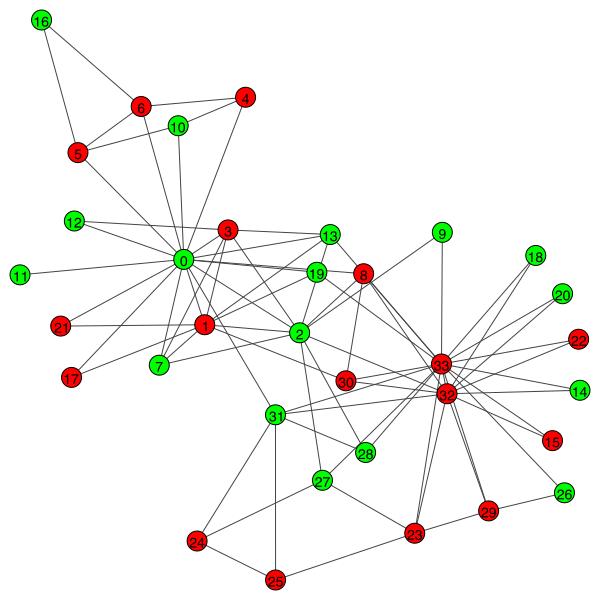

In [22]:
igraph.plot(p)

## Modularity

In [542]:
importlib.reload(methods)

p, vals, vecs = methods.modularity(largest)

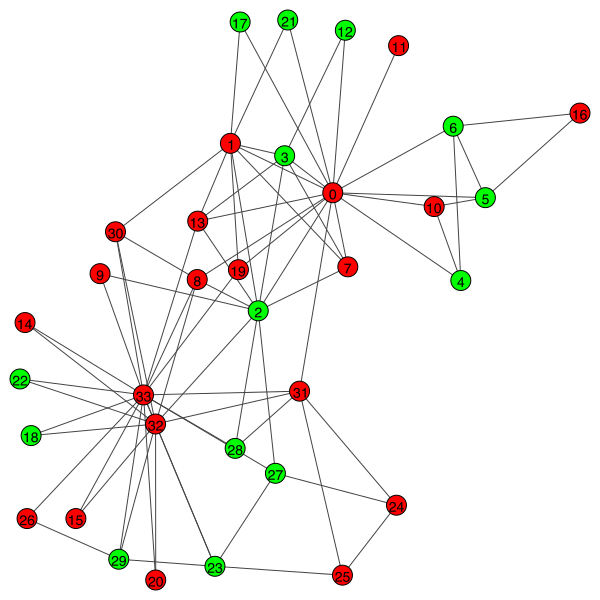

In [543]:
igraph.plot(p)

## iGraph Modularity

In [12]:
clust = largest.community_optimal_modularity()

In [30]:
cond(largest, clust.membership)

0.125

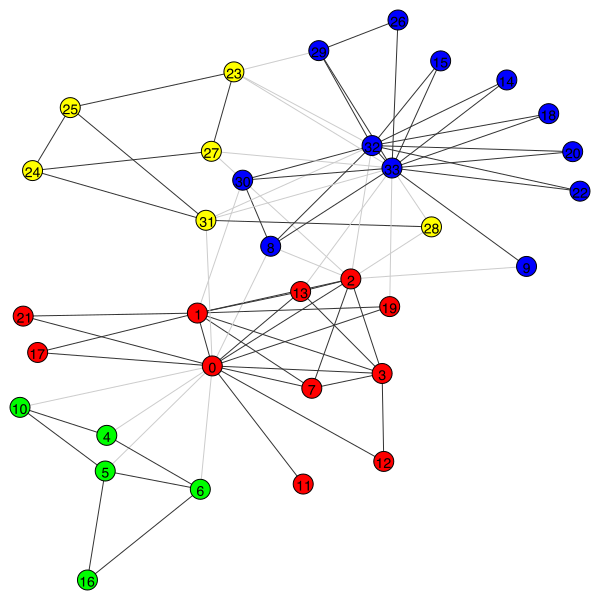

In [13]:
igraph.plot(clust)

In [32]:
clust = largest.community_leading_eigenvector()

In [33]:
cond(largest, clust.membership)

0.25

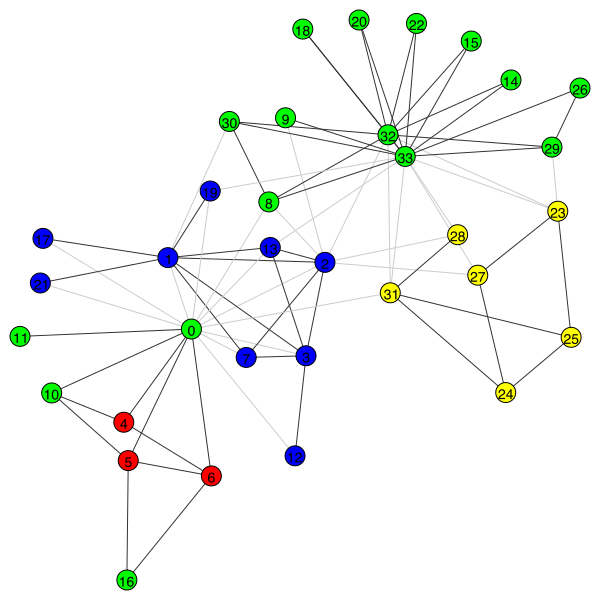

In [560]:
igraph.plot(clust)

## Edge Betweenness

In [34]:
importlib.reload(methods)

dend, clust = methods.edge_betweenness(largest)

In [35]:
cond(largest, clust.membership)

0.22033898305084745

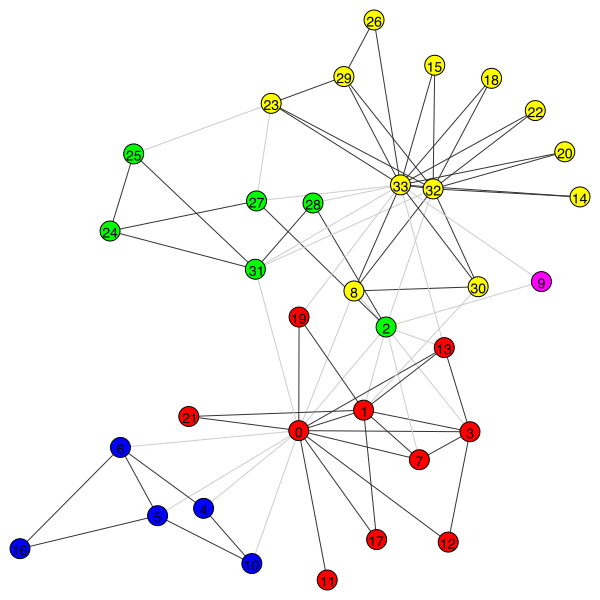

In [20]:
igraph.plot(clust)

## iGraph Edge Betweenness

In [36]:
dend = largest.community_edge_betweenness()
clust = dend.as_clustering()

In [37]:
cond(largest, clust.membership)

0.22033898305084745

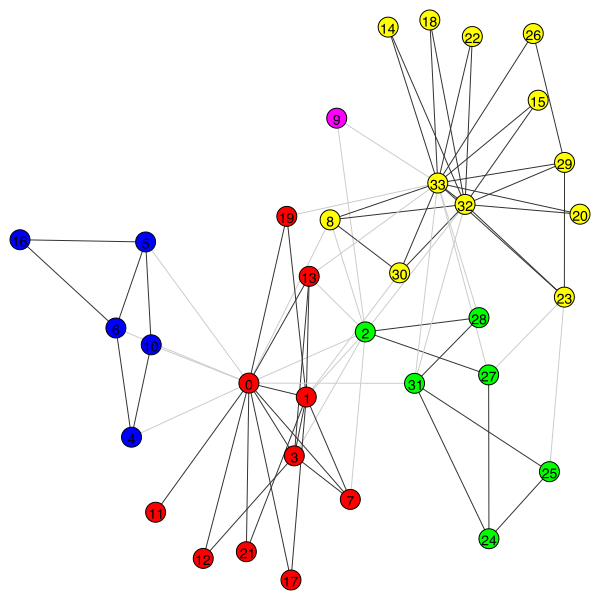

In [17]:
igraph.plot(clust)

## Walktrap Closed Form

In [38]:
importlib.reload(methods)

dend, clust = methods.walktrap_cf(largest)

In [39]:
cond(largest, clust.membership)

0.1111111111111111

In [11]:
mems = clust.membership
largest.vs['membership'] = mems
dend.optimal_count

3

In [5]:
def plot_memberships(g, cls, ms):
    palette = igraph.drawing.colors.ClusterColoringPalette(len(cls))
    colors = palette.get_many(ms)
    g.vs['color'] = colors
    g.vs['label'] = g.vs['id']
    layout = g.layout_auto()
    p = igraph.drawing.Plot(background='white')
    for m in range(len(set(ms))):
        p.add(cls.subgraph(m), opacity=0.6, layout=layout)
    return p

In [6]:
def plot_clusters(g, cls, ms):
    palette = igraph.drawing.colors.ClusterColoringPalette(len(cls))
    colors = palette.get_many(ms)
    g.vs['color'] = colors
    return igraph.plot(g, opacity=0.6)

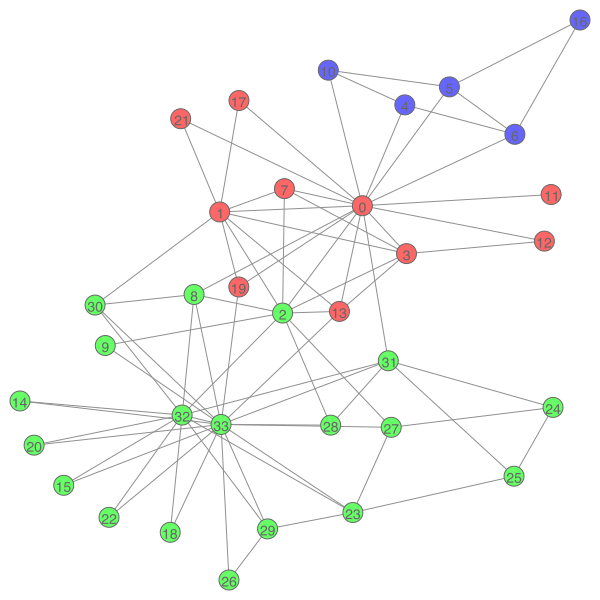

In [12]:
plot_clusters(largest, clust, mems)

## Walktrap Simulated

In [40]:
importlib.reload(methods)

dend, clust = methods.walktrap_sim(largest)

In [41]:
cond(largest, clust.membership)

0.1111111111111111

In [14]:
mems = clust.membership
largest.vs['membership'] = mems
dend.optimal_count

3

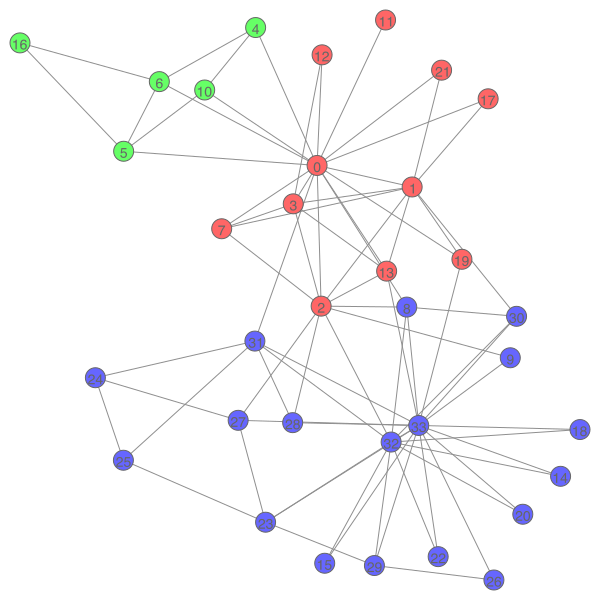

In [16]:
plot_clusters(largest, clust, mems)

## iGraph Walktrap

In [42]:
dendrogram = largest.community_walktrap()
dendrogram.optimal_count

5

In [43]:
clusters = dendrogram.as_clustering()
membership = clusters.membership

In [44]:
cond(largest, clust.membership)

0.1111111111111111

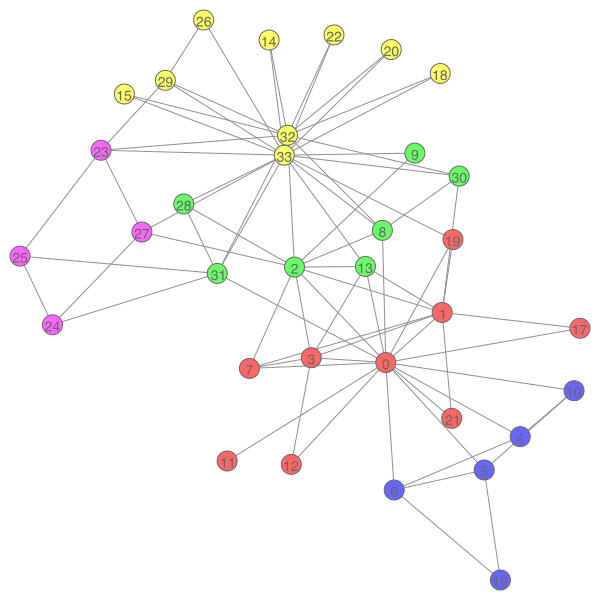

In [17]:
plot_clusters(largest, clusters, membership)